In [1]:
import torch
import pandas as pd
import numpy as np
import torchvision
import keras
import matplotlib.pyplot as plt
from torchvision import transforms
import tensorflow.keras
from PIL import Image
import cv2
from torch import nn
from torch.utils.data import TensorDataset, DataLoader
from tqdm import tqdm

2023-05-30 12:26:18.639364: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-05-30 12:26:18.671834: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-05-30 12:26:19.208410: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [2]:
dataset = tensorflow.keras.datasets.mnist.load_data()

In [3]:
(x_train, x_test), (y_train, y_test) = dataset

In [4]:
len(x_train)

60000

In [5]:
x_train[0].shape

(28, 28)

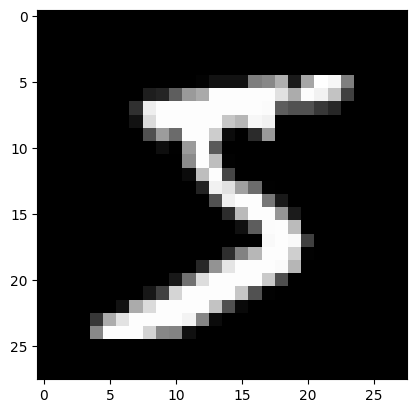

In [6]:
plt.imshow(x_train[0], cmap="gray")
plt.show()

In [7]:
def transforms_images(image):
    mean = 0
    std = 180
    noise = np.zeros(image.shape, np.uint8)
    noise_applied = cv2.randn(noise, mean, std)
    noisy_image = cv2.add(image, noise_applied)
    return noisy_image

In [8]:
noisy_images = [Image.fromarray(transforms_images(image)) for image in x_train]

In [9]:
len(noisy_images)

60000

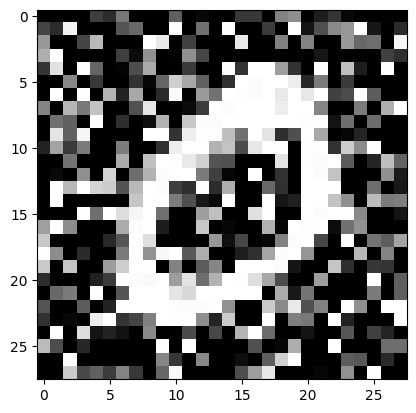

In [10]:
plt.imshow(noisy_images[1], cmap="gray")
plt.show()

In [11]:
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize([0.5], [0.5])
])

In [12]:
noisy_images_transformed = [transform(image) for image in noisy_images]

In [13]:
print(torch.max(noisy_images_transformed[0]), torch.min(noisy_images_transformed[0]))

tensor(1.) tensor(-1.)


In [14]:
type(noisy_images_transformed[0])

torch.Tensor

In [15]:
class Network(nn.Module):
    def __init__(self):
        super(Network, self).__init__()
        
        self.encoder = nn.Sequential(
            nn.Conv2d(1, 16, kernel_size=3, stride=2, padding=1),
            nn.ReLU(),
            nn.Conv2d(16, 32, kernel_size=3, stride=2, padding=1),
            nn.ReLU(),
            nn.Conv2d(32, 64, kernel_size=3, stride=2, padding=1),
            nn.ReLU()
        )
        
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(64, 32, kernel_size=2, stride=2, padding=1, output_padding=1),
            nn.ReLU(),
            nn.ConvTranspose2d(32, 16, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.ReLU(),
            nn.ConvTranspose2d(16, 1, kernel_size=3, stride=2, padding=1, output_padding=1),
        )
        
    def forward(self, image):
        encoder = self.encoder(image)
        decoder = self.decoder(encoder)
        return decoder

In [16]:
autoencoder = Network()

In [17]:
loss = nn.MSELoss()

In [18]:
lr = 0.006

In [19]:
optim = torch.optim.Adam(autoencoder.parameters(), lr)

In [20]:
data = torch.stack(noisy_images_transformed)
len(data)

60000

In [21]:
clear_images = [transform(image) for image in x_train]

In [22]:
data_clear = torch.stack(clear_images)

In [23]:
dataset_clear = TensorDataset(data_clear)

In [24]:
dataloader_clear = DataLoader(dataset_clear, batch_size=32, shuffle=False)

In [25]:
dataset = TensorDataset(data)

In [26]:
dataloader = DataLoader(dataset, batch_size=32, shuffle=False)

In [27]:
noisy_image = next(iter(dataloader))

In [28]:
def train_epoch(autoencoder, dataloader, optimizer):
    loss_fn = nn.MSELoss()
    for noisy_batch, clear_batch in zip(dataloader, dataloader_clear):
        for noisy_image, clear_image in zip(noisy_batch, clear_batch):
            decoded_data = autoencoder(noisy_image)
            loss = loss_fn(decoded_data, clear_image)
            
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

In [29]:
epochs = 20

In [30]:
for epoch in range(epochs):
    loss = train_epoch(autoencoder=autoencoder, dataloader=dataloader, optimizer=optim)

In [31]:
device = "cpu"

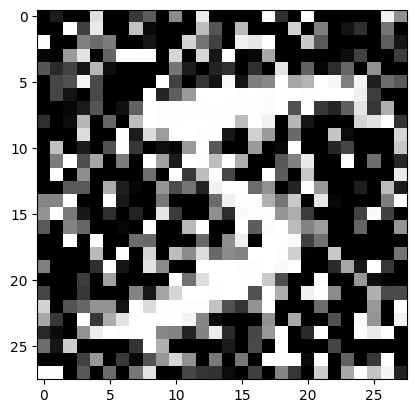

In [32]:
plt.imshow(noisy_images[0], cmap="gray")
plt.show()

In [33]:
predicted_image = autoencoder(noisy_images_transformed[0])
type(predicted_image)

torch.Tensor

In [34]:
predicted_image = predicted_image.detach().cpu().numpy()

In [35]:
np.max(predicted_image), np.min(predicted_image)

(1.2540064, -1.118816)

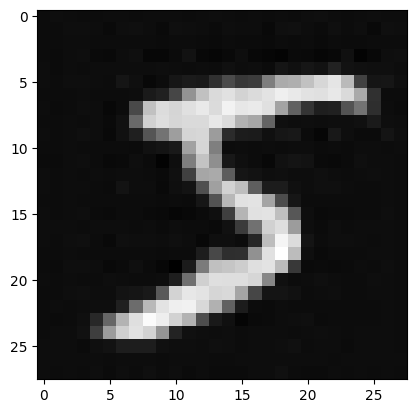

In [36]:
plt.imshow(np.reshape(predicted_image, (28,28,-1)), cmap="gray")
plt.show()